In [8]:
# Common imports
import numpy as np
import os
import pandas as pd

# Set random seed
np.random.seed(42)

# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message="^FutureWarning:")

In [9]:
ROOT_PATH = ".."
TITANIC_PATH = os.path.join(ROOT_PATH,"Data")

In [10]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path,filename)
    return pd.read_csv(csv_path, index_col=0, header=0)

In [11]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")
train_data.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

In [12]:
print("Name categories:",len(train_data["Name"].value_counts()))
print("Sex categories:",len(train_data["Sex"].value_counts()))
print("Ticket categories:",len(train_data["Ticket"].value_counts()))
print("Cabin categories:",len(train_data["Cabin"].value_counts()))
print("Embarked categories:",len(train_data["Embarked"].value_counts()))

Name categories: 891
Sex categories: 2
Ticket categories: 681
Cabin categories: 147
Embarked categories: 3


In [13]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [14]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

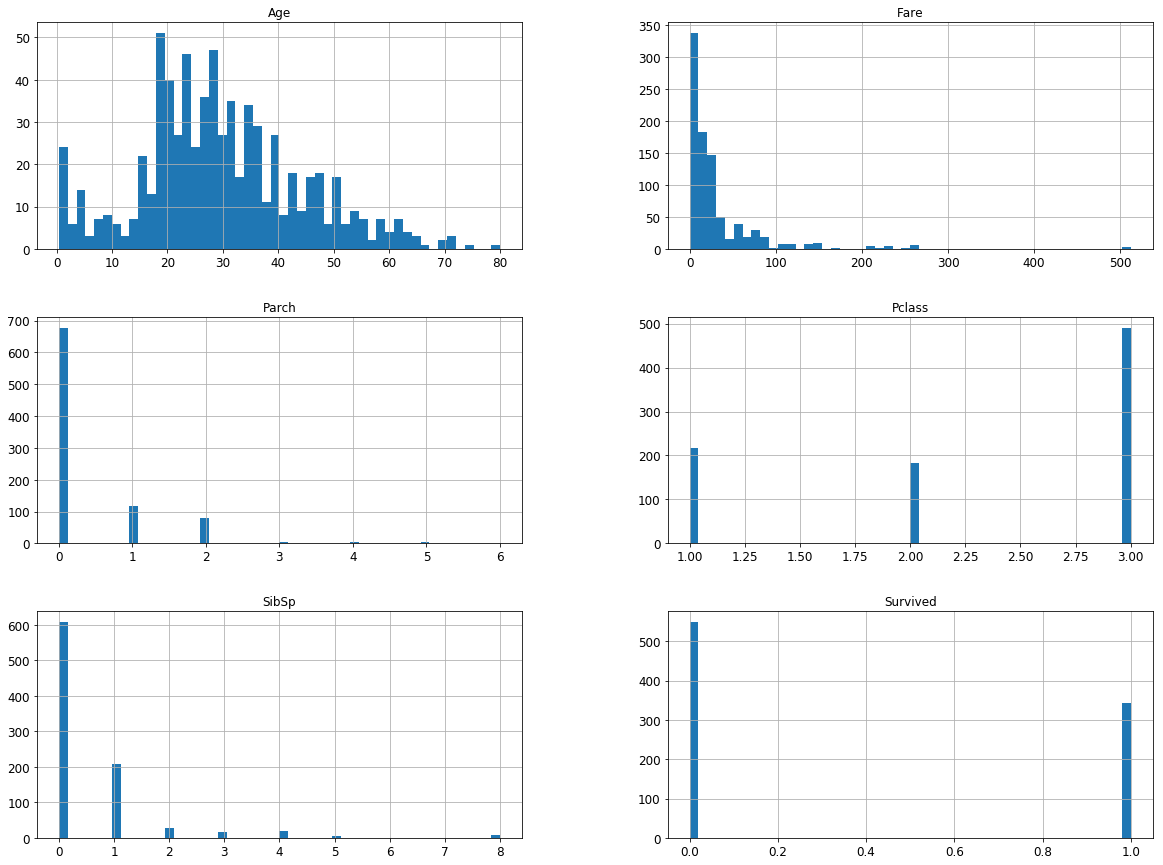

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data.hist(bins=50, figsize=(20,15))
plt.show()

# Preparation pipelines

Numerical pipeline

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')) # fill NAs with median value
])

Categorical pipeline

In [17]:
# Usarem un "na filler" semblant a SimpleImputer pero
# que retorni la categoria mes comu
# (stackoverflow.com/questions/25239958)

from sklearn.base import BaseEstimator, TransformerMixin

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [18]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

Full pipeline (apply numerical pipeline to numerical variables and so on)

In [19]:
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, ["Age", "SibSp", "Parch", "Fare"]),
    ('cat', cat_pipeline, ["Pclass", "Sex", "Embarked"])
])

#  Prepare datasets

In [20]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [21]:
y_train = train_data["Survived"]

In [25]:
X_test = preprocess_pipeline.fit_transform(test_data)

# Model testing

## Support Vector Classifier

In [26]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

## Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

## Visualize cross validation scores

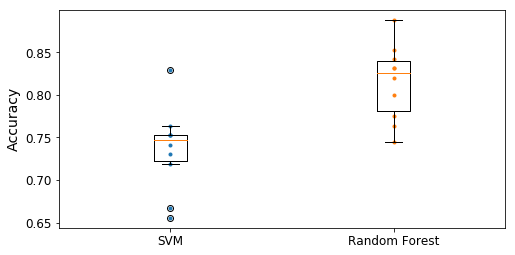

In [30]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

## Search for better Random Forest hyperparameters

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

forest_clf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(low=1, high=400),
    'max_features': randint(low=1, high=12)
}

rnd_search = RandomizedSearchCV(forest_clf, param_dist, cv=10, scoring='neg_mean_squared_error',
                           n_iter=50, random_state=42, verbose=2, n_jobs=2)
rnd_search.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 215 tasks      | elapsed:   23.4s
[Parallel(n_jobs=2)]: Done 497 out of 500 | elapsed:  1.0min remaining:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  1.0min finished
/home/oscar/virtualenvs/handson-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=2,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdb6318908>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdb63187b8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [27]:
rnd_search.best_params_

{'max_features': 10, 'n_estimators': 53}

In [33]:
cross_val_score(rnd_search.best_estimator_, X_train, y_train, cv=10).mean()

0.8261516853932583

In [34]:
# Dump best model
from sklearn.externals import joblib

python_dir_path = os.path.join(ROOT_PATH, "python")
models_path = os.path.join(python_dir_path, "models")
os.makedirs(models_path, exist_ok=True)

best_forest_path = os.path.join(models_path, "rnd_search_forest.pkl")
joblib.dump(rnd_search.best_estimator_, best_forest_path)

['../python/models/rnd_search_forest.pkl']

# Feature engineering

Replace SibSp and Parch by their sum

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

sibsp_iloc, parch_iloc = 1, 2

class RelativesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        relatives = X[:, sibsp_iloc] + X[:, parch_iloc]
        return np.c_[np.delete(X, [sibsp_iloc, parch_iloc], axis=1), relatives]

Create age bins

In [29]:
age_iloc = 0

class AgeBinsCreator(BaseEstimator, TransformerMixin):
    def __init__(self, bins):
        self.n_bins_ = bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        age_bins = X[:, age_iloc] // self.n_bins_ * self.n_bins_
        return np.c_[np.delete(X, age_iloc, axis=1), age_bins]

Entire pipeline

In [30]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('relatives', RelativesAdder()),
    ('agebins', AgeBinsCreator(15)),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('imputer', MostFrequentImputer()),
    ('onehot', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num', num_pipeline),
    ('cat', cat_pipeline),
])

full_pipeline.fit_transform(train_data)

array([[ 7.25  ,  1.    , 15.    , ...,  0.    ,  0.    ,  1.    ],
       [71.2833,  1.    , 30.    , ...,  1.    ,  0.    ,  0.    ],
       [ 7.925 ,  0.    , 15.    , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [23.45  ,  3.    , 15.    , ...,  0.    ,  0.    ,  1.    ],
       [30.    ,  0.    , 15.    , ...,  1.    ,  0.    ,  0.    ],
       [ 7.75  ,  0.    , 30.    , ...,  0.    ,  1.    ,  0.    ]])

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(low=1, high=400),
    'max_features': randint(low=1, high=12)
} 

rnd_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist,
                                cv=10, scoring='neg_mean_squared_error',
                                n_iter=50, random_state=42, verbose=2, n_jobs=2)

pipeline_with_predictor = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', rnd_search)
])

y_train = train_data["Survived"]

pipeline_with_predictor.fit(train_data, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 215 tasks      | elapsed:   21.6s
[Parallel(n_jobs=2)]: Done 497 out of 500 | elapsed:   56.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   56.3s finished


Pipeline(memory=None,
     steps=[('preprocessing', FeatureUnion(n_jobs=None,
       transformer_list=[('num', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Age', 'SibSp', 'Parch', 'Fare'])), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median'...=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2))])

In [39]:
pipeline_with_predictor.named_steps["model"].best_params_

{'max_features': 10, 'n_estimators': 22}

In [40]:
from sklearn.model_selection import cross_val_score

model = pipeline_with_predictor.named_steps["model"].best_estimator_
X_train = pipeline_with_predictor.named_steps["preprocessing"].transform(train_data)

cross_val_score(model, X_train, y_train, cv=10).mean()

0.8339788332765862

In [41]:
from sklearn.externals import joblib

python_dir_path = os.path.join(ROOT_PATH, "python")
models_path = os.path.join(python_dir_path, "models")
os.makedirs(models_path, exist_ok=True)

best_forest_path = os.path.join(models_path, "rnd_search_forest_new_features.pkl")
joblib.dump(rnd_search.best_estimator_, best_forest_path)

['../python/models/rnd_search_forest_new_features.pkl']

In [42]:
model.feature_importances_

array([0.31632726, 0.09021531, 0.10794773, 0.01547665, 0.00715056,
       0.09419478, 0.18045241, 0.14826792, 0.0135202 , 0.00629012,
       0.02015708])

In [43]:
X_train

array([[ 7.25  ,  1.    , 15.    , ...,  0.    ,  0.    ,  1.    ],
       [71.2833,  1.    , 30.    , ...,  1.    ,  0.    ,  0.    ],
       [ 7.925 ,  0.    , 15.    , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [23.45  ,  3.    , 15.    , ...,  0.    ,  0.    ,  1.    ],
       [30.    ,  0.    , 15.    , ...,  1.    ,  0.    ,  0.    ],
       [ 7.75  ,  0.    , 30.    , ...,  0.    ,  1.    ,  0.    ]])

In [44]:
train_data

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
6                   0       3   
7                   0       1   
8                   0       3   
9                   1       3   
10                  1       2   
11                  1       3   
12                  1       1   
13                  0       3   
14                  0       3   
15                  0       3   
16                  1       2   
17                  0       3   
18                  1       2   
19                  0       3   
20                  1       3   
21                  0       2   
22                  1       2   
23                  1       3   
24                  1       1   
25                  0       3   
26                  1       3   
27                  0       3   
28                  0       1   
29                  1       3   
30                  0       3   
...               ...     ...   
862                 0       2   
863                 1       1   
864                 0       3   
865                 0       2   
866                 1       2   
867                 1       2   
868                 0       1   
869                 0       3   
870                 1       3   
871                 0       3   
872                 1       1   
873                 0       1   
874                 0       3   
875                 1       2   
876                 1       3   
877                 0       3   
878                 0       3   
879                 0       3   
880                 1       1   
881                 1       2   
882                 0       3   
883                 0       3   
884                 0       2   
885                 0       3   
886                 0       3   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
6                                             Moran, Mr. James    male   NaN   
7                                      McCarthy, Mr. Timothy J    male  54.0   
8                               Palsson, Master. Gosta Leonard    male   2.0   
9            Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0   
10                         Nasser, Mrs. Nicholas (Adele Achem)  female  14.0   
11                             Sandstrom, Miss. Marguerite Rut  female   4.0   
12                                    Bonnell, Miss. Elizabeth  female  58.0   
13                              Saundercock, Mr. William Henry    male  20.0   
14                                 Andersson, Mr. Anders Johan    male  39.0   
15                        Vestrom, Miss. Hulda Amanda Adolfina  female  14.0   
16                            Hewlett, Mrs. (Mary D Kingcome)   female  55.0   
17                                        Rice, Master. Eugene    male   2.0   
18                                Williams, Mr. Charles Eugene    male   NaN   
19           Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0   
20                                     Masselmani, Mrs. Fatima  female   NaN   
21                                        Fynney, Mr. Joseph J    male  35.0   
22                                       Beesley, Mr. Lawrence    male  34.0   
23           

In [45]:
# TODO: get column labels for X_train to check feature importances

## XGBoost

In [46]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


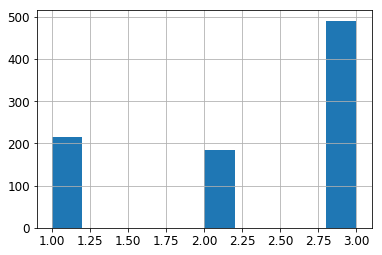

In [47]:
train_data["Pclass"].hist()
plt.show()

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit # we will stratify by Pclass (no NAs there)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_data, train_data["Pclass"]):
    strat_train_set = train_data.loc[train_index]
    strat_test_set = train_data.loc[test_index]

X_train = full_pipeline.fit_transform(strat_train_set)
y_train = strat_train_set["Survived"]

/home/oscar/virtualenvs/handson-ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [49]:
import xgboost as xgb

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, random_state=42)

xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [50]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
from sklearn.model_selection import cross_val_score
xg_scores = cross_val_score(xg_cl, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
xg_rmse_scores = np.sqrt(-xg_scores)
display_scores(xg_rmse_scores)

Scores: [0.44095855 0.35355339 0.44095855 0.44405304 0.41111323 0.37529331
 0.39361095 0.44405304 0.37529331 0.50709255]
Mean: 0.4185979916460155
Standard deviation: 0.04334623389750186


In [51]:
cross_val_score(xg_cl, X_train, y_train, cv=10).mean()

0.8228968253968254

In [52]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': randint(low=1, high=400),
    'learning_rate': [0.004, 0.02, 0.1, 0.4]
} 

rnd_search = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', random_state=42),
                                param_dist, cv=10, scoring='neg_mean_squared_error',
                                n_iter=50, random_state=42, verbose=2, n_jobs=2)

pipeline_with_predictor = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', rnd_search)
])
y_train = train_data["Survived"]

pipeline_with_predictor.fit(train_data, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  86 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   25.3s finished


Pipeline(memory=None,
     steps=[('preprocessing', FeatureUnion(n_jobs=None,
       transformer_list=[('num', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Age', 'SibSp', 'Parch', 'Fare'])), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median'...=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2))])

With GPU would be something like:

```Python
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': randint(low=1, high=300),
} 

rnd_search = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', random_state=42,
                                                  tree_method='gpu_hist'),
                                param_dist, cv=10, scoring='neg_mean_squared_error',
                                n_iter=50, random_state=42, verbose=2, n_jobs=1)

pipeline_with_predictor = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', rnd_search)
])
y_train = train_data["Survived"]

pipeline_with_predictor.fit(train_data, y_train)
```

In [53]:
pipeline_with_predictor.named_steps["model"].best_params_

{'learning_rate': 0.4, 'n_estimators': 55}

In [54]:
from sklearn.model_selection import cross_val_score

model = pipeline_with_predictor.named_steps["model"].best_estimator_
X_train = pipeline_with_predictor.named_steps["preprocessing"].transform(train_data)

cross_val_score(model, X_train, y_train, cv=10).mean()

0.8463258994438771

In [55]:
from sklearn.externals import joblib

python_dir_path = os.path.join(ROOT_PATH, "python")
models_path = os.path.join(python_dir_path, "models")
os.makedirs(models_path, exist_ok=True)

xgb_clf_path = os.path.join(models_path, "xgb_clf_new_features.pkl")
joblib.dump(rnd_search.best_estimator_, best_forest_path)

['../python/models/xgb_clf_new_features.pkl']

In [6]:
from sklearn.externals import joblib

python_dir_path = os.path.join(ROOT_PATH, "python")
models_path = os.path.join(python_dir_path, "models")
xgb_clf_path = os.path.join(models_path, "xgb_clf_new_features.pkl")
model = joblib.load(xgb_clf_path)

In [35]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc').mean()

0.8644289675466146